## First define the models 

In [1]:
import torch
import torch.nn as nn

from loss_objectives import GCCA_loss
import scipy.linalg as lg

class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size):
        super(MlpNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1])
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1]),
                    nn.ReLU(),
                ))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class DeepGCCA(nn.Module):
    def __init__(self, layer_sizes_list, input_size_list, device=torch.device('cpu')):
        super(DeepGCCA, self).__init__()
        self.model_list = []
        for i in range(len(layer_sizes_list)):
            self.model_list.append(MlpNet(layer_sizes_list[i], input_size_list[i]).double())
        self.model_list = nn.ModuleList(self.model_list)
        self.loss = GCCA_loss


    def forward(self, x_list):
        """

        x_%  are the vectors needs to be make correlated
        dim = [batch_size, features]

        """
        # feature * batch_size
        output_list = []
        for x, model in zip(x_list, self.model_list):
            output_list.append(model(x)) 

        return output_list

def g_step(M_list):
    M = 0
    k = M_list[0].shape[1]
    for i in range(len(M_list)):
        M += M_list[i]
    U, S, V = torch.svd(M, some=True)
    return torch.matmul(U, V.transpose(1,0))

## Synthetic Data

In [2]:
import numpy as np
import scipy
import scipy.io
import scipy.linalg

# import seaborn as sns

import math

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd

import torch

import os

def create_synthData(N=400, outDir='./', device='cpu'):
    '''
    creating Main paper Synth data,
    N : number of data
    F$ : number of features in view $ 
    '''
    views  = []
    k  = 2   # Number of latent features
    F1 = 2   
    F2 = 2   
    F3 = 2 

    # First half of points belong to class 1, second to class 2
    G = np.zeros( ( N, k ) )
    
    G[:int(N/2),0] = 1.0
    G[int(N/2):,1] = 1.0
    classes = ['Class1' for i in range(int(N/2))] + ['Class2' for i in range(int(N/2))] 

    # Each class lies on a different concentric circle
    rand_angle = np.random.uniform(0.0, 2.0 * math.pi, (N, 1) )
    rand_noise = 0.1 * np.random.randn(N, k)
    circle_pos = np.hstack( [np.cos(rand_angle), np.sin(rand_angle)])
    radius     = G.dot(np.asarray( [[1.0], [2.0]] )).reshape( (N, 1) )
    V1    = np.hstack([radius, radius]) * circle_pos + rand_noise
    views.append(V1)
    
    # Each class lies on a different parabola
    rand_x     = np.random.uniform(-3.0, 3.0, (N, 1) )
    rand_noise = 0.1 * np.random.randn(N, k)
    intercepts = G.dot( np.asarray([[0.0], [1.0]])).reshape( (N, 1) )
    quadTerms  = G.dot( np.asarray( [[2.0], [0.5]] )).reshape( (N, 1) )
    V2    = np.hstack( [rand_x, intercepts + quadTerms * (rand_x*rand_x)]) + rand_noise
    views.append(V2) 

    # Class on inside is drawn from a gaussian, class on outside is on a concentric circle
    rand_angle = np.random.uniform(0.0, 2.0 * math.pi, (N, 1) )
    inner_rand_noise = 1.0 * np.random.randn(int(N/2), k) # More variance on inside
    outer_rand_noise = 0.1 * np.random.randn(int(N/2), k)
    rand_noise = np.vstack( [outer_rand_noise, inner_rand_noise] )
    circle_pos = np.hstack( [np.cos(rand_angle), np.sin(rand_angle)])
    radius     = G.dot(np.asarray( [[2.0], [0.0]] )).reshape( (N, 1) )
    V3    = np.hstack([radius, radius]) * circle_pos + rand_noise
    views.append(V3)

    # We have no missing data
    K = np.ones( (N, 3) )
    
    # Gather into dataframes to plot

    dfs = []
    for v in views:
      df = pd.DataFrame(v, columns=['x', 'y'])
      df['Classes'] = classes
      dfs.append(df)
    
#     # Plot to PDF
#     with PdfPages(os.path.join(outDir, 'originalData.pdf')) as pdf:
#       for viewIdx, df in enumerate(dfs):
#         fig = sns.lmplot(x="x", y="y", fit_reg=False, markers=['+', 'o'], legend=False, hue="Classes", data=df).fig
#         plt.legend(loc='best')
#         plt.title('View %d' % (viewIdx))
#         pdf.savefig()
#         plt.close(fig)
  
    views = [torch.tensor(view).to(device) for view in views]
    return views, classes



In [37]:
views, classes = create_synthData()
colors = 200*[1]+ 200*[3]

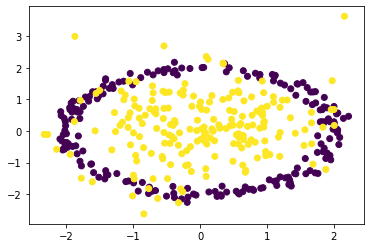

In [38]:
plt.scatter(views[2][:,0], views[2][:,1], c=colors)


## Plots

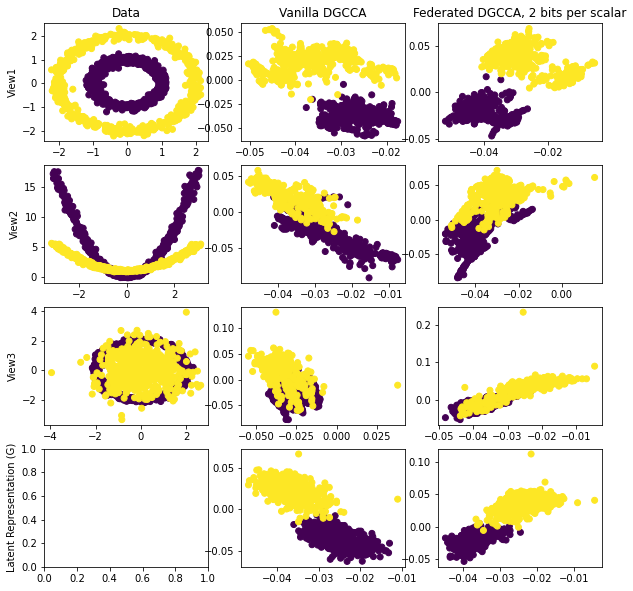

In [34]:
dgcca_vanilla = torch.load('trained_models/dgcca1.model')
dgcca_fed = torch.load('trained_models/dgcca_federated1.model')

train_views, classes = create_synthData(N=1000)
val_views, classes = create_synthData(N=200)

train_views = [view.to(device) for view in train_views]
val_views = [view.to(device) for view in val_views]

out1 = dgcca_vanilla(train_views)
out1 = [a.to('cpu').detach() for a in out1]


out1 = dgcca_vanilla(train_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.to('cpu').detach() for a in out1]

out2 = dgcca_fed(train_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.to('cpu').detach() for a in out2]

G1 = G1.detach().to('cpu')
G2 = G2.detach().to('cpu')

target = [t.to('cpu').detach() for t in train_views]

fig, axes = plt.subplots(4,3, figsize=(10,10))

axes[0,0].set_title('Data')
axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
axes[0,0].set_ylabel('View1')
axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
axes[1,0].set_ylabel('View2')
axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
axes[2,0].set_ylabel('View3')
axes[3,0].set_ylabel('Latent Representation (G)')

axes[0,1].set_title("Vanilla DGCCA")
axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
axes[3,1].scatter(G1[:,0], G1[:,1], c=500*[1]+500*[2])

axes[0,2].set_title("Federated DGCCA, 2 bits per scalar")
axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
axes[3,2].scatter(G2[:,0], G2[:,1], c=500*[1]+500*[2])


## Plots mini batch GD

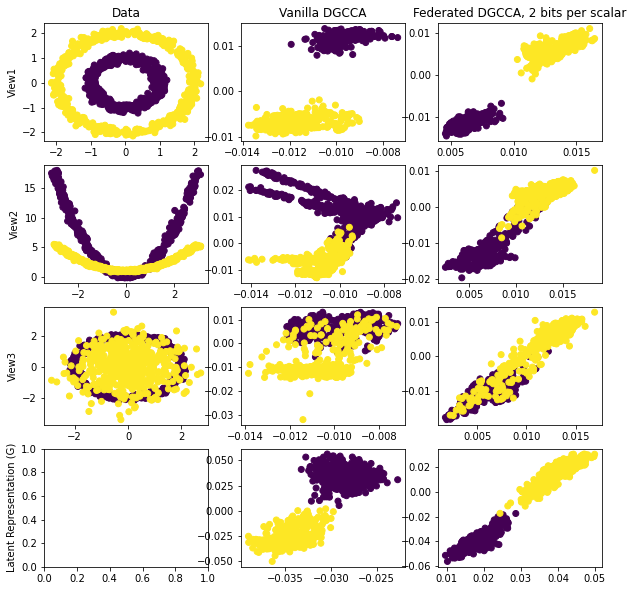

In [58]:
dgcca_vanilla = torch.load('trained_models/dgcca_sgd2.model')
dgcca_fed = torch.load('trained_models/dgcca_federated_sgd1.model')

train_views, classes = create_synthData(N=1000)
val_views, classes = create_synthData(N=200)

train_views = [view.to(device) for view in train_views]
val_views = [view.to(device) for view in val_views]

out1 = dgcca_vanilla(train_views)
out1 = [a.to('cpu').detach() for a in out1]


out1 = dgcca_vanilla(train_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.to('cpu').detach() for a in out1]

out2 = dgcca_fed(train_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.to('cpu').detach() for a in out2]

G1 = G1.detach().to('cpu')
G2 = G2.detach().to('cpu')

target = [t.to('cpu').detach() for t in train_views]

fig, axes = plt.subplots(4,3, figsize=(10,10))

axes[0,0].set_title('Data')
axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
axes[0,0].set_ylabel('View1')
axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
axes[1,0].set_ylabel('View2')
axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
axes[2,0].set_ylabel('View3')
axes[3,0].set_ylabel('Latent Representation (G)')

axes[0,1].set_title("Vanilla DGCCA")
axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
axes[3,1].scatter(G1[:,0], G1[:,1], c=500*[1]+500*[2])

axes[0,2].set_title("Federated DGCCA, 2 bits per scalar")
axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
axes[3,2].scatter(G2[:,0], G2[:,1], c=500*[1]+500*[2])


In [109]:
fig.savefig('plt/scatter_plots_sgd_toy.pdf')

## Classification error

In [100]:
vanilla = torch.load('trained_models/dgcca_sgd_classifier.model')
fed = torch.load('trained_models/dgcca_fed_sgd_classifier.model')

train_views, train_classes = create_synthData(N=1000)

train_views = [view.to(device) for view in train_views]

# out1 = dgcca_vanilla(train_views)

out1 = dgcca_vanilla(train_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.type(torch.float32).detach() for a in out1]

out2 = dgcca_fed(train_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.type(torch.float32).detach() for a in out2]

vanilla_class = []
for i in range(3):
    a = vanilla.model_list[i](out1[i])
    vanilla_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = vanilla.model_list[3](G1.type(torch.float32))
vanilla_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())


fed_class = []
for i in range(3):
    a = fed.model_list[i](out2[i])
    fed_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = fed.model_list[3](G2.type(torch.float32))
fed_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())

In [101]:
fed_class

[tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(44., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(78., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>)]

In [102]:
vanilla_class

[tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(41., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(85., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>)]

In [107]:
[1-i/1000 for i in fed_class]

[tensor(1., device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9560, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9220, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9990, device='cuda:0', grad_fn=<RsubBackward1>)]

In [108]:
[1-i/1000 for i in vanilla_class]

[tensor(1., device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9590, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9150, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(1., device='cuda:0', grad_fn=<RsubBackward1>)]

In [78]:
a = classifier.model_list[1](out1[1])
(a.squeeze().round() - train_classes[1].to('cuda'))

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  

In [75]:
train_classes[0].shape

torch.Size([1000])

In [76]:
a.shape

torch.Size([1000, 1])

In [65]:
train_classes

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

## Plot the curves

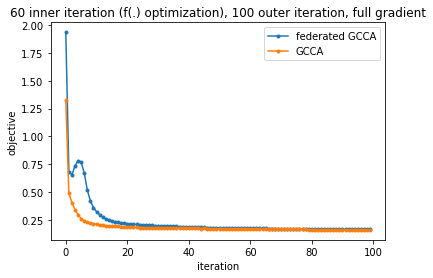

In [23]:
# fig, axes = plt.subplots(1,2, figsize=(10,10))
# plt.figsize=(20, 20)

plt.plot(df3['data_fidelity'], marker='.')
plt.plot(df2['data_fidelity'], marker='.')
plt.legend(['federated GCCA', 'GCCA'])
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title('60 inner iteration (f(.) optimization), 100 outer iteration, full gradient')

plt.savefig('plt/convergence.pdf')

In [17]:
1000/16

62.5

## DGCCA

In [45]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA
from synth_data import create_synthData

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [10]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=10000)
    val_views, classes = create_synthData(N=200)
    
    train_views = [view.to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    

    
    for epoch in range(50):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        ## initialize G
        dgcca.eval()
        out = dgcca(train_views)
        out = torch.stack(out)  
        G = g_step(out.clone().detach())
        
        dgcca.train()
        for j in range(run.inner_epochs):
            for i in range(num_batches):
                optimizer.zero_grad()
                batch = []
                
                # SGD
#                 batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
#                 target = G[(i*run.batch_size):((i+1)*run.batch_size), :]

                # full gradient
                batch = train_views
                target = G

                out = dgcca(batch)
                out = torch.stack(out)  
                
                loss = 1/2*torch.norm(out-target)/target.shape[0]
                
#                 print(loss.item())
                
                loss.backward()
                optimizer.step()
                
                total_recons_loss += loss.item()
                
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = 1/2*torch.norm(out_val - G_val)/G_val.shape[0]
        total_val_loss += loss_val.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches*run.inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_full.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000442,0.005316,1000,0.001,cuda
1,1,1,0.000090,0.005247,1000,0.001,cuda
2,1,2,0.000079,0.005167,1000,0.001,cuda
3,1,3,0.000072,0.005197,1000,0.001,cuda
4,1,4,0.000066,0.005140,1000,0.001,cuda
5,1,5,0.000061,0.005161,1000,0.001,cuda
6,1,6,0.000057,0.005139,1000,0.001,cuda
7,1,7,0.000055,0.005148,1000,0.001,cuda
8,1,8,0.000054,0.005162,1000,0.001,cuda
9,1,9,0.000053,0.005150,1000,0.001,cuda


## SGD

In [55]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA
from synth_data import create_synthData

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [50],
    quant = [True]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=10000)
    val_views, classes = create_synthData(N=200)
    suffler = torch.randperm(10000)
    
    train_views = [view[suffler].to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    # init G
    dgcca.eval()
    out = dgcca(train_views)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    dgcca.train()
    
    for epoch in range(50):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for j in range(run.inner_epochs):
            for i in range(num_batches):
                optimizer.zero_grad()
                batch = []
                
                # SGD
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :]

                # full gradient
#                 batch = train_views
#                 target = G

                out = dgcca(batch)
                out = torch.stack(out)  
                
                loss = 1/2*torch.norm(out-target)/target.shape[0]
                
#                 print(loss.item())
                
                loss.backward()
                optimizer.step()
                
                total_recons_loss += loss.item()
                
        ## Update G
        dgcca.eval()
        out = dgcca(train_views)
        out = torch.stack(out)
        
        if run.quant:
            for i in range(len(train_views)):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                M_serv[i] += M_quant
            G = g_step(M_serv.clone().detach())          
        else:
            G = g_step(out.clone().detach())  
            
        
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = 1/2*torch.norm(out_val - G_val)/G_val.shape[0]
        total_val_loss = loss_val.item()

        dgcca.train()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches*run.inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_federated_sgd1.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000638,0.005610,1000,0.001,cuda
1,1,1,0.000363,0.005618,1000,0.001,cuda
2,1,2,0.000372,0.005755,1000,0.001,cuda
3,1,3,0.000395,0.005765,1000,0.001,cuda
4,1,4,0.000387,0.005709,1000,0.001,cuda
5,1,5,0.000368,0.005684,1000,0.001,cuda
6,1,6,0.000379,0.005672,1000,0.001,cuda
7,1,7,0.000344,0.005713,1000,0.001,cuda
8,1,8,0.000322,0.005677,1000,0.001,cuda
9,1,9,0.000312,0.005608,1000,0.001,cuda


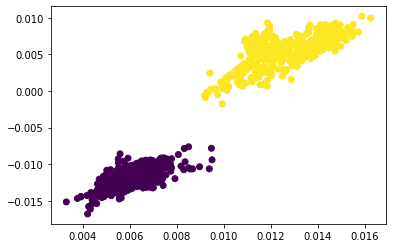

In [56]:
train_views, classes = create_synthData(N=1000)
val_views, classes = create_synthData(N=200)

train_views = [view.to(device) for view in train_views]
val_views = [view.to(device) for view in val_views]
out = dgcca(train_views)
out = [a.to('cpu').detach() for a in out]

plt.scatter(out[0][:,0], out[0][:,1], c=500*[1]+500*[2])

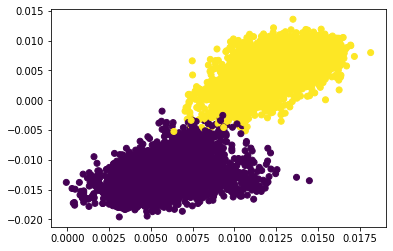

In [57]:
G = G.to('cpu').detach()
classes = 5000*[1]+5000*[2]
# classes = classes[list(suffler.numpy())]
suffled_c = [classes[i] for i in list(suffler) ]
plt.scatter(G[:,0], G[:,1], c=suffled_c)

## Classifier DGCCA

In [60]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA, DGCCAClassifierToy
from synth_data import create_synthData
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.BCELoss],
    num_views = [4]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):

    run_count += 1
    device = torch.device(run.device)
    
    classifier = DGCCAClassifierToy(num_views=run.num_views)
    classifier.to(device)
    dgcca = torch.load('trained_models/dgcca_federated_sgd1.model')
    dgcca.eval()
    
    train_views, train_classes = create_synthData(N=10000)
    val_views, val_classes = create_synthData(N=200)
    suffler = torch.randperm(10000)
    
    train_classes.append(train_classes[0])
    val_classes.append(val_classes[0])
    
    
    train_classes = [view[suffler].to(device).unsqueeze(dim=1) for view in train_classes]
    val_classes = [view.to(device).unsqueeze(dim=1) for view in val_classes]
    
    train_views = [view[suffler].to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    train_out = dgcca(train_views)
    train_G = g_step(torch.stack(train_out).clone().detach().type(torch.float32))

    val_out = dgcca(val_views)
    val_G = g_step(torch.stack(val_out).clone().detach().type(torch.float32))
   
    train_out = [view.detach().clone().type(torch.float32) for view in train_out]
    train_out.append(train_G)
    val_out = [view.type(torch.float32) for view in val_out]
    val_out.append(val_G)
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    for epoch in range(500):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []

            # SGD
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_out]            
            target = [view[(i*run.batch_size):((i+1)*run.batch_size)] for view in train_classes] 

            out = classifier(batch)

            loss = classifier.loss_backward(out, target)
            optimizer.step()

            total_recons_loss += np.array(loss).mean()

        # validation loss
        out_val = classifier(val_out)
        loss = criterion(torch.stack(out_val), torch.stack(val_classes))
        total_val_loss = loss.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(classifier, 'trained_models/dgcca_fed_sgd_classifier.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.486031,0.294981,1000,0.001,cuda
1,1,1,0.236538,0.206504,1000,0.001,cuda
2,1,2,0.180581,0.168944,1000,0.001,cuda
3,1,3,0.152388,0.150434,1000,0.001,cuda
4,1,4,0.137654,0.139176,1000,0.001,cuda
...,...,...,...,...,...,...,...
495,1,495,0.074978,0.087942,1000,0.001,cuda
496,1,496,0.074912,0.087764,1000,0.001,cuda
497,1,497,0.075006,0.088805,1000,0.001,cuda
498,1,498,0.074974,0.088191,1000,0.001,cuda


In [50]:
a = classifier.model_list[0](val_out[0])

b = (a.round() - val_classes[0])

b.abs().sum()

In [2]:
batch[0]

tensor([[-0.0093,  0.0126],
        [-0.0118, -0.0069],
        [-0.0098,  0.0100],
        ...,
        [-0.0112, -0.0051],
        [-0.0100,  0.0125],
        [-0.0097, -0.0079]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward>)

In [ ]:
a = BCE

In [37]:
a = [1, 3, 4]

[1, 3, 4, 1, 3, 4, 1, 3, 4]

In [42]:
import numpy as np
np.array(a).mean()

2.6666666666666665

In [40]:
import math

math.mean(a)

AttributeError: module 'math' has no attribute 'mean'

## Federated DGCCA for toy 2D example

In [2]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [16],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=1000)
    val_views, classes = create_synthData(N=200)
    
    train_views = [view.to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    out = dgcca(train_views)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
            target = G[(i*run.batch_size):((i+1)*run.batch_size), :]
            
            # full gradient
            batch = train_views
            target = G
            
            out = dgcca(batch)
            out = torch.stack(out)  
            # G = g_step(out.clone().detach())
            loss = 1/3*torch.norm(out-target)
            loss.backward()
            optimizer.step()
            total_recons_loss += loss.item()
            
        ## initialize G
        out = dgcca(train_views)
        out = torch.stack(out)
        
        for i in range(I):
            M_diff[i] = out[i] - M_serv[i]
            max_val = M_diff[i].abs().max()
            M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
            M_serv[i] += M_quant
        G = g_step(M_serv.clone().detach())    
        
        
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_federated1.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,1.936397,0.003102,16,0.001,cuda
1,1,1,0.682871,0.003156,16,0.001,cuda
2,1,2,0.653893,0.002993,16,0.001,cuda
3,1,3,0.733880,0.003569,16,0.001,cuda
4,1,4,0.781140,0.003783,16,0.001,cuda
...,...,...,...,...,...,...,...
95,1,95,0.162442,0.001911,16,0.001,cuda
96,1,96,0.162157,0.001908,16,0.001,cuda
97,1,97,0.162470,0.001890,16,0.001,cuda
98,1,98,0.162947,0.001922,16,0.001,cuda


## DGCCA CelebA

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, CelebaDGCCA
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = CelebaDGCCA()
    dgcca = dgcca.to(device)

    transform = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

    dataset = datasets.ImageFolder('/scratch/sagar/Projects/flow/glow-pytorch/data/img_align_celeba', transform=transform)
    dataloader = DataLoader(dataset, shuffle=False, batch_size=run.batch_size, num_workers=4)
    dataloader = iter(dataloader)

    train_views, _ = next(dataloader)
    val_views = train_views[:1000,:,:,:].clone()
    train_views = [train_views[:,i,:,:] for i in range(train_views.shape[1])]
    train_views = [view.to(device).unsqueeze(dim=1) for view in train_views]
    
#     val_views, _ = next(dataloader)
    
    val_views = [val_views[:,i,:,:] for i in range(val_views.shape[1])]
    val_views = [view.to(device).unsqueeze(dim=1) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//200
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//200
    
    out = dgcca(train_views)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
#             batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
#             target = G[(i*run.batch_size):((i+1)*run.batch_size), :]
            
#             batch = [view.to(device).unsqueeze(dim=1) for view in batch]
            
            # full gradient
            batch = train_views
            target = G
            
            out = dgcca(batch)
            out = torch.stack(out)  
            # G = g_step(out.clone().detach())
            loss = 1/3*torch.norm(out-target)
            loss.backward()
            optimizer.step()
            total_recons_loss += loss.item()
            
        ## initialize G
        out = dgcca(train_views)
        out = torch.stack(out)
        
        for i in range(I):
            M_diff[i] = out[i] - M_serv[i]
            max_val = M_diff[i].abs().max()
            M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
            M_serv[i] += M_quant
        G = g_step(M_serv.clone().detach())    

        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches/10
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_celeba.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,2.388504,0.039285,1000,0.001,cuda
1,1,1,0.938792,0.012180,1000,0.001,cuda
2,1,2,0.601284,0.005594,1000,0.001,cuda
3,1,3,0.475366,0.004040,1000,0.001,cuda
4,1,4,0.386858,0.001990,1000,0.001,cuda
5,1,5,0.329158,0.002183,1000,0.001,cuda
6,1,6,0.309780,0.002006,1000,0.001,cuda


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.92 GiB total capacity; 9.14 GiB already allocated; 12.00 MiB free; 9.20 GiB reserved in total by PyTorch)

In [67]:
    train_views, _ = next(dataloader)
    train_views = [train_views[:,i,:,:] for i in range(train_views.shape[1])]

In [70]:
len(train_views[0])

10000

In [55]:
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder('/scratch/sagar/Projects/flow/glow-pytorch/data/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, shuffle=False, batch_size=1000, num_workers=4)
dataloader = iter(dataloader)

train_views, _ = next(dataloader)

train_views = [train_views[i] for i in range(len(train_views))]

In [65]:
train_views[0].shape

torch.Size([3, 64, 64])

In [ ]:
train+_

In [32]:
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder('/scratch/sagar/Projects/flow/glow-pytorch/data/img_align_celeba', transform=transform)

In [51]:
a = dataset[]


ValueError: too many values to unpack (expected 2)

202599

In [39]:
b

0

AttributeError: 'tuple' object has no attribute 'shape'

In [56]:
M_diff[0].abs().max()

tensor(1.0724, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)

In [59]:
M_diff[0].round()

tensor([[-0., 0.],
        [0., 0.],
        [-0., 0.],
        ...,
        [0., 1.],
        [0., 0.],
        [-0., 1.]], device='cuda:0', dtype=torch.float64,
       grad_fn=<RoundBackward>)

## Plot

In [26]:
import torch.nn as nn
import torch.nn.functional as F 
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms 
import torch.optim as optim
from tqdm import tqdm, trange

from torch.utils.tensorboard import SummaryWriter
from itertools import product
from slf_dataset import SLFDataset
import os

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class CelebaNet(nn.Module):
    def __init__(self, output_size=10):
        super(CelebaNet, self).__init__()
        ndf = 16
        nc = 1
        self.main = nn.Sequential(
            # input is (nc) x 51 x 51
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.SELU(),

            # state size. (ndf) x 25 x 25
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SELU(),
            
            # state size. (ndf*2) x 12 x 12
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SELU(),
            
            # state size. (ndf*4) x 6 x 6
            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SELU(),
            
            # state size. (ndf*8) x 3 x 3
            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False),
            nn.SELU(),

            Flatten(), 
            nn.Linear(256, output_size)
        )

    def forward(self, input):
        return self.main(input)

In [27]:
a = CelebaNet()

In [28]:
b = a(torch.randn((1, 1,64,64)))

In [29]:
b.shape

torch.Size([1, 10])

In [ ]:
b.